# Classification of handwritten characters based on IMU data


In [398]:
# imports

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
from tensorflow import keras


import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import string

For each character of the 26 lowercase characters in the alphabet 20 recordings were made. One recording consists of a csv file for the tablet data and a csv file for the IMU data. The data was merged based on the system's time_stamp, precisely the tablet data was merged onto the IMU data. 


### Pre-processing

#### For each sequence of letters we create an IMU and a tablet dataframe

In [399]:
# read data into dataframes
# some have additonal segments which need to be deleted

# note that the tablet data collection was started earlier and ended earlier

data_types_imu = {
    'host_timestamp': str,
    'arduino_timestamp': int,
    'ax': float,
    'ay': float,
    'az': float,
    'gx': float,
    'gy': float,
    'gz': float,
}

data_types_tab = {
    'host_timestamp': str,
    'x': float,
    'y': float,
    'z': float,
    'in_range': int,
    'touch': float,
    'pressure': float,
    'reset': int
}

tab_columns = ['host_timestamp', 'x', 'y', 'z', 'in_range', 'touch', 'pressure', 'reset']

# Path to the character_data folder
folder_path = "./data/character_data"

# List all the CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# Loop through the CSV files
for csv_file in csv_files:

    # Extract the letter from the CSV filename
    letter = csv_file.split("_")[0]

    # letters h,c and g have additional segments that need to be filtered out

    # we read the host_timestamp as string and trim it so we can convert it to a numerical type to later merge on it (avoid overflow)
    # we convert arduino_timestamp into seconds


    if letter == "g" and csv_file.split("_")[1].split(".")[0] == "imu":
        df_imu = pd.read_csv(folder_path + "/" + csv_file, encoding='UTF-16', usecols=range(0,8), dtype=data_types_imu, nrows=3147)
        df_imu['host_timestamp'] = df_imu['host_timestamp'].str[2:-2]
        df_imu['host_timestamp'] = df_imu['host_timestamp'].astype(np.int64)
        df_imu['arduino_timestamp'] = df_imu['arduino_timestamp'] * 1e-3

        globals()["imu_" + letter] = df_imu

    elif letter == "h" and csv_file.split("_")[1].split(".")[0] == "imu":
        df_imu = pd.read_csv(folder_path + "/" + csv_file, encoding='UTF-16', usecols=range(0,8), dtype=data_types_imu, nrows=2785)
        df_imu['host_timestamp'] = df_imu['host_timestamp'].str[2:-2]
        df_imu['host_timestamp'] = df_imu['host_timestamp'].astype(np.int64)
        df_imu['arduino_timestamp'] = df_imu['arduino_timestamp'] * 1e-3

        globals()["imu_" + letter] = df_imu
    
    elif letter == "c" and csv_file.split("_")[1].split(".")[0] == "tab":
        df_tab= pd.read_csv(folder_path + "/" + csv_file, encoding='UTF-8', skiprows= 276, header = None)
        df_tab.columns = tab_columns
        df_tab = df_tab.astype(data_types_tab)
        df_tab['host_timestamp'] = df_tab['host_timestamp'].str[2:-2]
        df_tab['host_timestamp'] = df_tab['host_timestamp'].astype(np.int64)

        globals()["tab_" + letter] = df_tab

    # read IMU data

    elif csv_file.split("_")[1].split(".")[0] == "imu":
        df_imu = pd.read_csv(folder_path + "/" + csv_file, encoding='UTF-16', usecols=range(0,8), dtype=data_types_imu)
        df_imu['host_timestamp'] = df_imu['host_timestamp'].str[2:-2]
        df_imu['host_timestamp'] = df_imu['host_timestamp'].astype(np.int64)
        df_imu['arduino_timestamp'] = df_imu['arduino_timestamp'] * 1e-3

        globals()["imu_" + letter] = df_imu

    # read tablet data

    else:
        df_tab = pd.read_csv(folder_path + "/" + csv_file, encoding='UTF-8', dtype=data_types_tab)
        df_tab['host_timestamp'] = df_tab['host_timestamp'].str[2:-2]
        df_tab['host_timestamp'] = df_tab['host_timestamp'].astype(np.int64)


        globals()["tab_" + letter] = df_tab
    
    

In [400]:
imu_a.head(2)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz
0,62765837634,342.641,-5.6243,-2.3605,7.9896,-0.0134,-0.0476,0.0012
1,62765950593,342.653,-5.6124,-2.4263,8.0339,-0.0134,-0.0440,-0.0073


#### We merge the tablet and IMU data for each character sequence

In [401]:
# merge data
def merge(imu_df, tab_df):
    # tablet recording starts earlier and ends earlier
    start = np.min(imu_df.host_timestamp)
    end = np.max(tab_df.host_timestamp)
    
    # we use imu_data as base
    df = imu_df[imu_df["host_timestamp"] <= end].copy()

    tab_df = tab_df[tab_df["host_timestamp"] >= start]
    tab_time_span = np.linspace(np.min(tab_df["host_timestamp"]), np.max(tab_df["host_timestamp"]), len(df))

    # interpolate tablet data to the same time span but according to the tablet time values
    for column in ['x', 'y', 'touch']:
        df[column] = np.interp(tab_time_span, tab_df["host_timestamp"], tab_df[column])

    return df

In [402]:
def merge_asof(imu_df, tab_df):
    
    # tablet recording starts earlier and ends earlier
    start = imu_df['host_timestamp'].min()
    end = tab_df['host_timestamp'].max()

    tab_df = tab_df[tab_df['host_timestamp'] >= start]
    imu_df = imu_df[imu_df['host_timestamp'] <= end]

    # Merge data frames using merge_asof
    merged_df = pd.merge_asof(
        imu_df, tab_df, 
        on='host_timestamp', 
        direction='nearest'
    )

    return merged_df

In [403]:
for letter in string.ascii_lowercase:
    tab_df = globals()["tab_" + letter]
    imu_df = globals()["imu_" + letter]
    globals()[letter] = merge_asof(imu_df, tab_df)
    

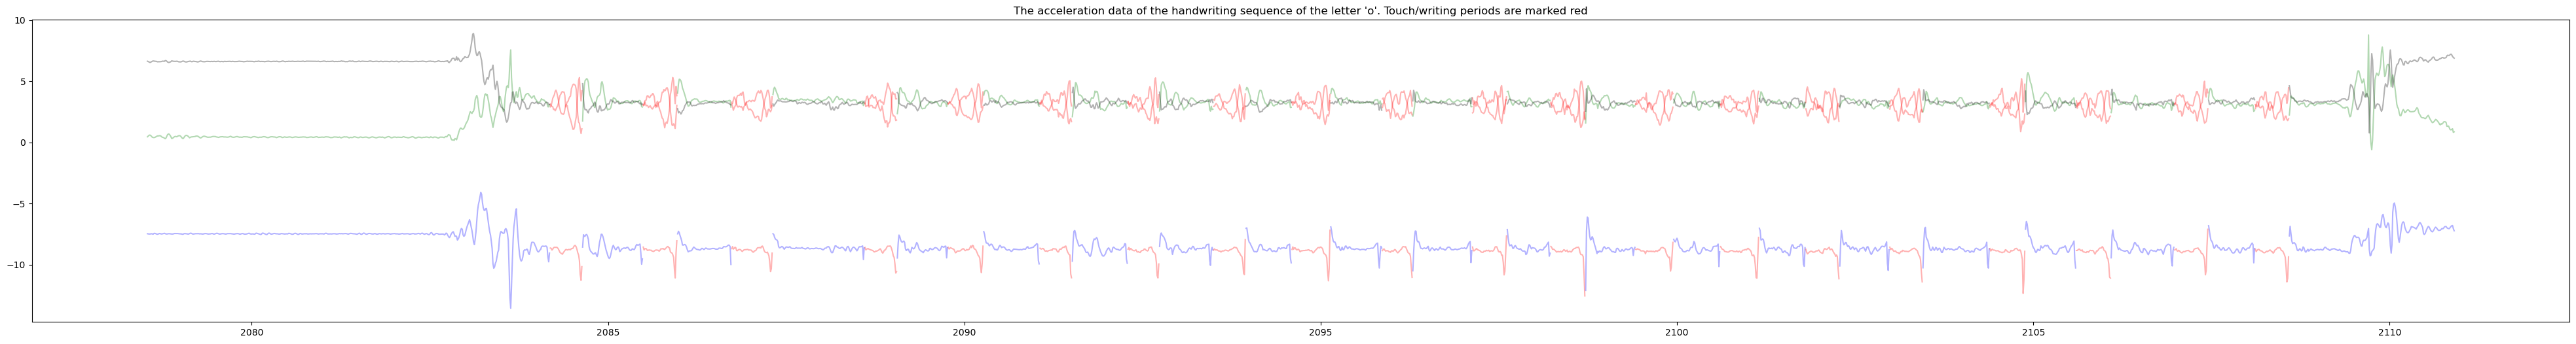

In [404]:
plt.figure(figsize=(50, 6))
is_touch = o["touch"] == 1
plt.plot(o['arduino_timestamp'].where(~is_touch), o['ax'].where(~is_touch), c='blue', alpha= 0.3)
plt.plot(o['arduino_timestamp'].where(is_touch), o['ax'].where(is_touch), c='red', alpha= 0.3)
plt.plot(o['arduino_timestamp'].where(~is_touch), o['ay'].where(~is_touch), c='green', alpha= 0.3)
plt.plot(o['arduino_timestamp'].where(is_touch), o['ay'].where(is_touch), c='red', alpha= 0.3)
plt.plot(o['arduino_timestamp'].where(~is_touch), o['az'].where(~is_touch), c='black', alpha= 0.3)
plt.plot(o['arduino_timestamp'].where(is_touch), o['az'].where(is_touch), c='red', alpha= 0.3)
plt.title("The acceleration data of the handwriting sequence of the letter 'o'. Touch/writing periods are marked red")
plt.show()

#### Splitting the character sequences/dataframes into the writing of the single characters in each sequence


In [405]:
def split_into_individual_chars(df):
    is_touch = df["touch"] == 1
    prev = 0
    segments = []
    start = 0
    end = 0
    for i in range(len(is_touch)-1):
        if is_touch[i] == True and prev == False:
            start = i
        elif is_touch[i] == False and prev == True:
            end = i-1
            segments.append(df.iloc[start:end])
        prev = is_touch[i]

    return segments

In [406]:
for letter in string.ascii_lowercase:
    df = globals()[letter]
    globals()[letter + "_segments"] = split_into_individual_chars(df)

In [407]:
def merge_segments_for_two_stroke_chars(segments):
    new_segments = []
    for i in range(1,len(segments), 2):        
        seg = segments[i-1].append(segments[i], ignore_index=True)
        new_segments.append(seg)
    return new_segments

In [408]:
def merge_segments_for_y(segments):
    new_segments = []
    new_segments.append(segments[0])
    for i in range(2,len(segments), 2):        
        seg = segments[i-1].append(segments[i], ignore_index=True)
        new_segments.append(seg)
    return new_segments


In [409]:
for letter in ["i","j","f","k","t","x","y"]:
    if letter == "y":
        globals()[letter + "_segments"] = merge_segments_for_y(globals()[letter + "_segments"])
    elif letter == "j":
        globals()[letter + "_segments"] = merge_segments_for_two_stroke_chars(globals()[letter + "_segments"])
    else:
        globals()[letter + "_segments"] = merge_segments_for_two_stroke_chars(globals()[letter + "_segments"])

# i is not ok, j is one missing bzw. das fünfte segment enhält zwei j, y hat das erste element vollständig
# use scatter to plot these characters

C:\Users\ann-k\AppData\Local\Temp\ipykernel_37684\3277293848.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seg = segments[i-1].append(segments[i], ignore_index=True)
C:\Users\ann-k\AppData\Local\Temp\ipykernel_37684\1244694982.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seg = segments[i-1].append(segments[i], ignore_index=True)


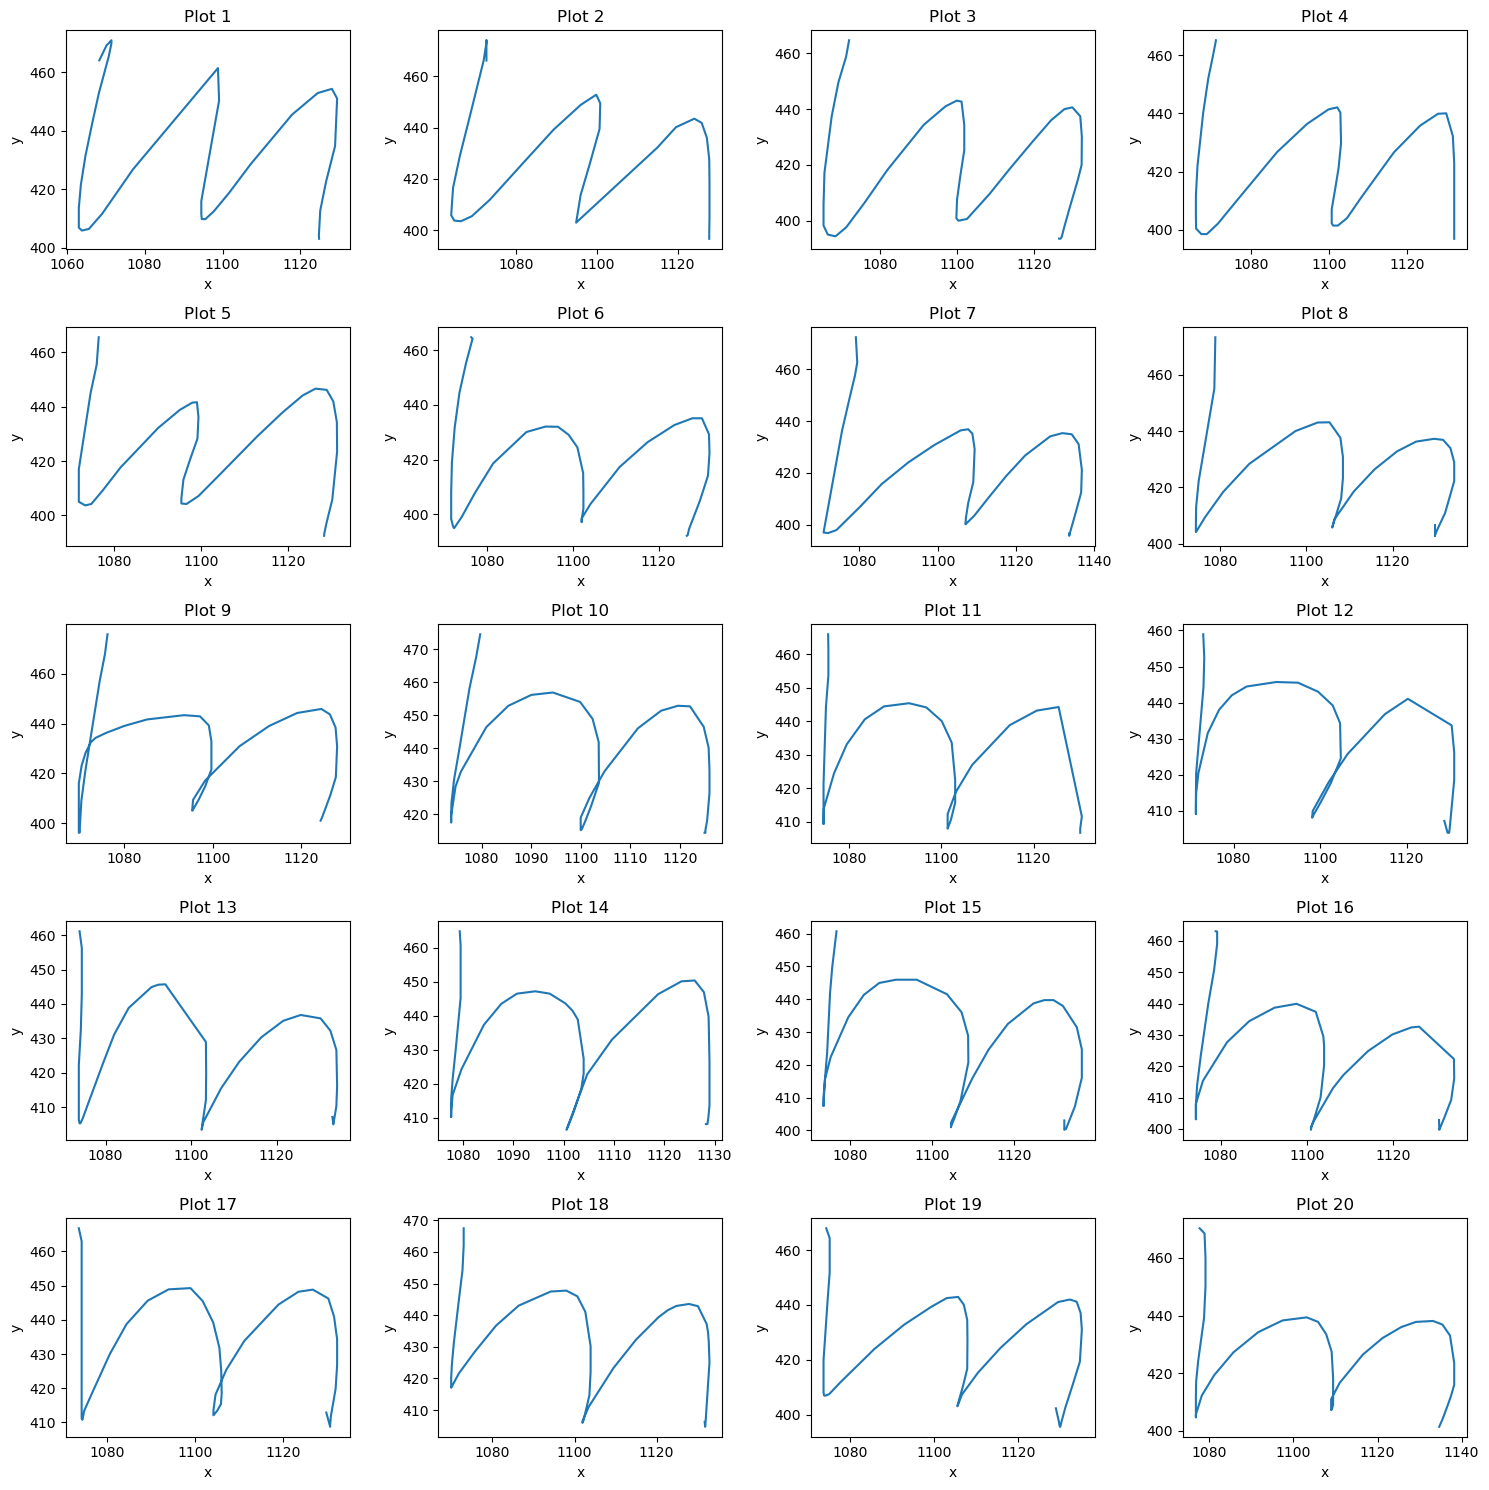

In [410]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))  # Adjust the figsize as per your preference

for i in range(20):
    row = i // 4  # Row index for subplot
    col = i % 4   # Column index for subplot
    
    axs[row, col].plot(m_segments[i]["x"], m_segments[i]["y"])
    axs[row, col].set_title(f"Plot {i+1}")
    axs[row, col].set_xlabel("x")
    axs[row, col].set_ylabel("y")

plt.tight_layout()  # Adjust subplot spacing
plt.savefig("m_series.png")
plt.show()


In [411]:
# store single characters (this is for a different purpose than this notebook)
file_path = './data/single_chars/'

for letter in string.ascii_lowercase:
    list = globals()[letter + "_segments"]
    # Save the DataFrame as a CSV file
    list[0].to_csv(file_path + "{}.csv".format(letter), index=False)

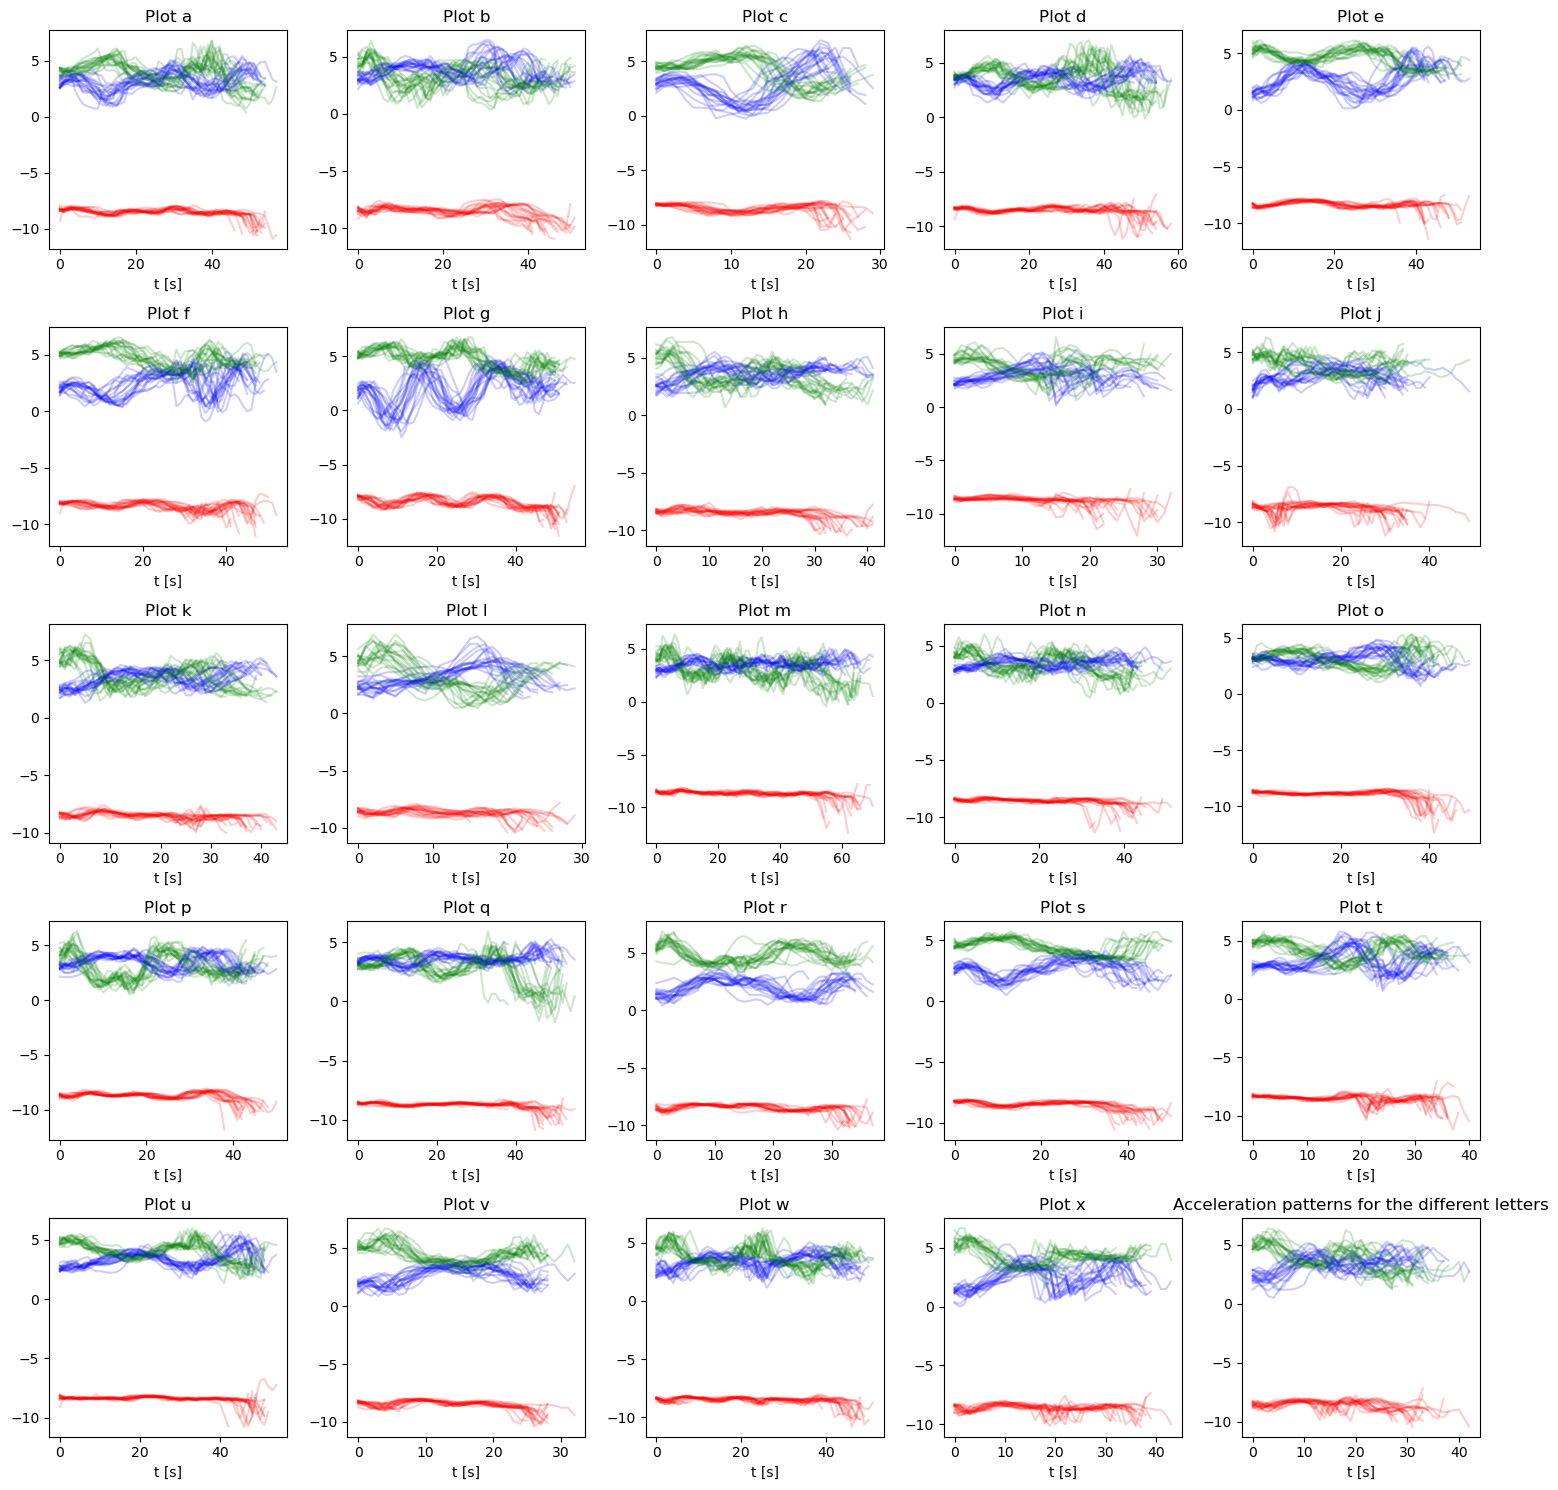

In [412]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15)) 

for j in range(25):
    row = j // 5  # Row index for subplot
    col = j % 5   # Column index for subplot

    segments = globals()[string.ascii_lowercase[j] + "_segments"]
    for i in range(0, 19):
        axs[row, col].plot(range(len(segments[i]["ax"])), segments[i]["ax"], label=f'Index {i}', alpha=0.2, c= "red")  
        axs[row, col].plot(range(len(segments[i]["ay"])), segments[i]["ay"], label=f'Index {i}', alpha=0.2, c= "blue")
        axs[row, col].plot(range(len(segments[i]["az"])), segments[i]["az"], label=f'Index {i}', alpha=0.2, c= "green")
        axs[row, col].set_title(f"Plot {i+1}")
        axs[row, col].set_title(f"Plot {string.ascii_lowercase[j]}")
        axs[row, col].set_xlabel("t [s]")

plt.tight_layout()  # Adjust subplot spacing
plt.title("Acceleration patterns for the different letters")
plt.savefig("acc_data_chars.png")
plt.show()

In [413]:
# how long are the segments in terms of data points per letter
segment_lengths = {}
for letter in string.ascii_lowercase:
    s = globals()[letter + "_segments"]
    segment_lengths[letter] = (np.mean([len(df) for df in s]))
segment_lengths

{'a': 51.9,
 'b': 46.8,
 'c': 26.05,
 'd': 53.3,
 'e': 45.85,
 'f': 46.35,
 'g': 51.9,
 'h': 36.55,
 'i': 26.45,
 'j': 35.21052631578947,
 'k': 38.6,
 'l': 24.904761904761905,
 'm': 63.15,
 'n': 42.85,
 'o': 41.8,
 'p': 45.05,
 'q': 49.6,
 'r': 34.65,
 's': 44.8,
 't': 35.5,
 'u': 50.05,
 'v': 27.95,
 'w': 47.5,
 'x': 36.45,
 'y': 33.1,
 'z': 32.85}

In [414]:
max_segment_lengths = []
for letter in string.ascii_lowercase:
    s = globals()[letter + "_segments"]
    max_segment_lengths.append((np.max([len(df) for df in s])))

max_length = np.max(max_segment_lengths)
print(f"The longest segment is of length: {max_length}")

The longest segment is of length: 75


In [415]:
# for each character choose 2 as validation, 18 for training and 2 for testing

X_training = []
X_test = []
X_val = []
y_training = []
y_test = []
y_val = []


for letter in string.ascii_lowercase:
    s = globals()[letter + "_segments"]
    for i in range(len(s) - 1):
        if i < 2 :
            sequence = s[i][["ax", "ay", "az", "gx", "gy", "gz"]].values
            padded_sequence = pad_sequences([sequence], maxlen=max_length, dtype='float32', padding='post', truncating='post')[0]
            X_val.append(padded_sequence)
            y_val.append(letter)
        elif i < 18:
            sequence = s[i][["ax", "ay", "az", "gx", "gy", "gz"]].values
            padded_sequence = pad_sequences([sequence], maxlen=max_length, dtype='float32', padding='post', truncating='post')[0]
            X_training.append(padded_sequence)
            y_training.append(letter)

            smaller_sequence = sequence[::2]
            padded_smaller_sequence = pad_sequences([smaller_sequence], maxlen=max_length, dtype='float32', padding='post', truncating='post')[0]
            X_training.append(padded_smaller_sequence)
            y_training.append(letter)
        else:
            sequence = s[i][["ax", "ay", "az", "gx", "gy", "gz"]].values
            padded_sequence = pad_sequences([sequence], maxlen=max_length, dtype='float32', padding='post', truncating='post')[0]
            X_test.append(padded_sequence)
            y_test.append(letter)

In [416]:
X_training = np.stack(X_training)
y_training = np.stack(y_training)

X_val = np.stack(X_val)
y_val = np.stack(y_val)

X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [417]:
label_encoder = LabelEncoder()
y_training = label_encoder.fit_transform(y_training)
y_val = label_encoder.fit_transform(y_val)

In [418]:
def map_label_to_letter(label):
    return string.ascii_lowercase[label]

In [419]:
# Define the input shape
input_shape = (75, 6)

# Create the sequential model
model = keras.Sequential()

# Masking layer to handle variable-length sequences
model.add(keras.layers.Masking(mask_value=0., input_shape=(None, 6)))

# LSTM layers with recurrent dropout and kernel regularization
model.add(keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.LSTM(64, recurrent_dropout=0.2, kernel_regularizer=keras.regularizers.l2(0.01)))

# Dense layer with dropout regularization
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Output layer with softmax activation for classification
model.add(keras.layers.Dense(26, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)


In [420]:
X_training.shape

(832, 75, 6)

Epoch 1/100
42/42 [==============================] - 20s 316ms/step - loss: 5.2293 - accuracy: 0.0433 - val_loss: 4.3888 - val_accuracy: 0.0385
Epoch 2/100
42/42 [==============================] - 12s 291ms/step - loss: 3.9184 - accuracy: 0.0625 - val_loss: 3.4044 - val_accuracy: 0.0769
Epoch 3/100
42/42 [==============================] - 12s 295ms/step - loss: 3.2292 - accuracy: 0.0853 - val_loss: 3.0101 - val_accuracy: 0.1538
Epoch 4/100
42/42 [==============================] - 14s 327ms/step - loss: 2.8346 - accuracy: 0.1382 - val_loss: 2.6734 - val_accuracy: 0.0769
Epoch 5/100
42/42 [==============================] - 14s 327ms/step - loss: 2.5758 - accuracy: 0.1743 - val_loss: 2.5645 - val_accuracy: 0.1731
Epoch 6/100
42/42 [==============================] - 14s 328ms/step - loss: 2.4269 - accuracy: 0.2055 - val_loss: 2.7342 - val_accuracy: 0.1923
Epoch 7/100
42/42 [==============================] - 15s 368ms/step - loss: 2.2896 - accuracy: 0.2248 - val_loss: 2.4377 - val_accuracy:

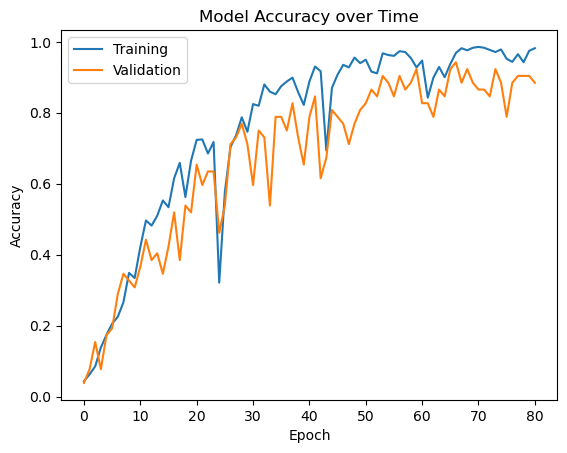

In [421]:
history = model.fit(X_training, y_training, epochs=100, batch_size=20, validation_data=(X_val, y_val), callbacks=[callback]) 

# Plotting accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Model Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("model_accuracy.png")
plt.show()

In [424]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X = X_training
y = y_training


kfold = KFold(n_splits=5)  # 5-fold cross-validation
scores = []
for train_index, test_index in kfold.split(X):
    X_train, X_test_k = X[train_index], X[test_index]
    y_train, y_test_k = y[train_index], y[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    score = model.evaluate(X_test_k, y_test_k)
    scores.append(score)

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))

6/6 [==============================] - 1s 116ms/step - loss: 0.1259 - accuracy: 1.0000
Cross-Validation Scores: [[0.16104571521282196, 0.9880239367485046], [0.32341253757476807, 0.9281437397003174], [0.16098326444625854, 0.9819276928901672], [0.129519984126091, 1.0], [0.12591971457004547, 1.0]]
Mean Accuracy: 0.5798976585268975
Standard Deviation: 0.40349589287053317


1/1 [==============================] - 0s 96ms/step


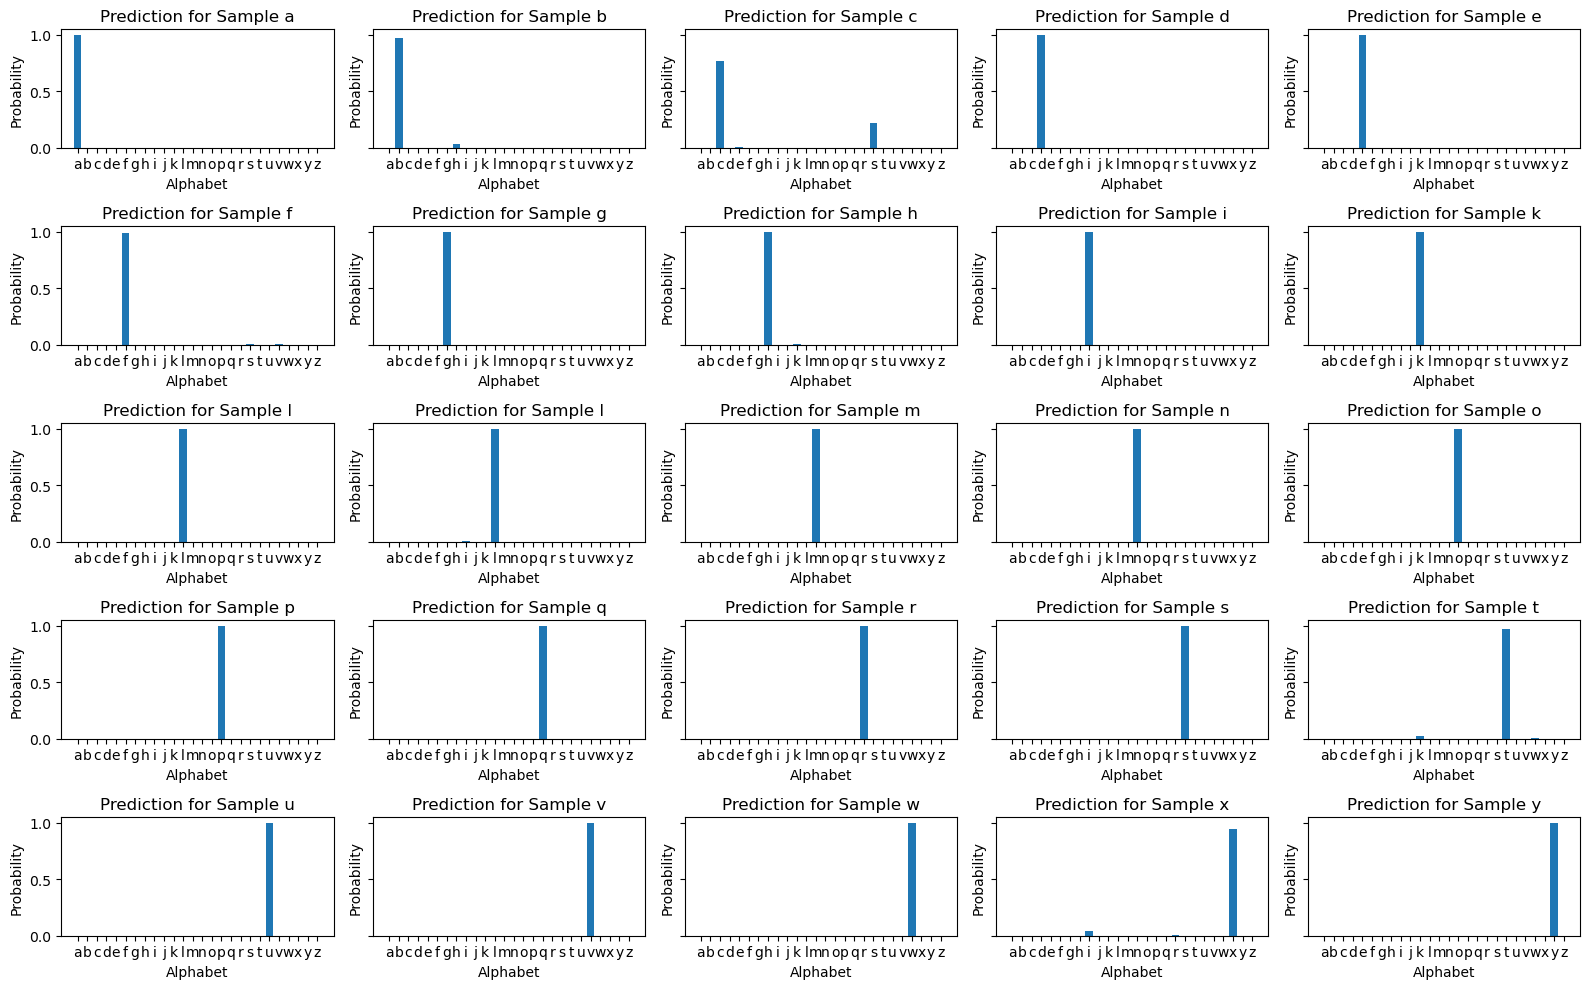

In [425]:
alphabet = string.ascii_lowercase

# Create the figure and subplots
fig, axs = plt.subplots(5, 5, figsize=(16, 10), sharey=True)

# Reshape the subplots to 1D for easier indexing
axs = axs.flatten()

# Loop through the predictions for each value in X_test
for i in range(25):
    predictions = model.predict(np.expand_dims(X_test[i],axis= 0))
    
    # Plot the bar chart for the predictions
    axs[i].bar(range(26), predictions.flatten())
    axs[i].set_title(f"Prediction for Sample {y_test[i]}")
    axs[i].set_xlabel("Alphabet")
    axs[i].set_ylabel("Probability")
    
    axs[i].set_xticks(range(26))
    axs[i].set_xticklabels(alphabet)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [426]:
# Create an empty prediction matrix
prediction_matrix = np.zeros((len(X_training) + len(X_test), 26))

# Predict labels for X_train
train_predictions = model.predict(X_training)
prediction_matrix[:len(X_training)] = train_predictions

# Predict labels for X_test
test_predictions = model.predict(X_test)
prediction_matrix[len(X_training):] = test_predictions

1/1 [==============================] - 0s 130ms/step


In [427]:
max_indices = np.argmax(prediction_matrix, axis=1).reshape(-1,)

In [428]:
max_indices = [string.ascii_lowercase[int(label)] for label in max_indices]

In [429]:
y_training = [string.ascii_lowercase[int(label)] for label in y_training]

In [430]:
true_labels = np.concatenate((y_training, y_test)).reshape(-1,)

In [431]:
true_labels.shape

(858,)

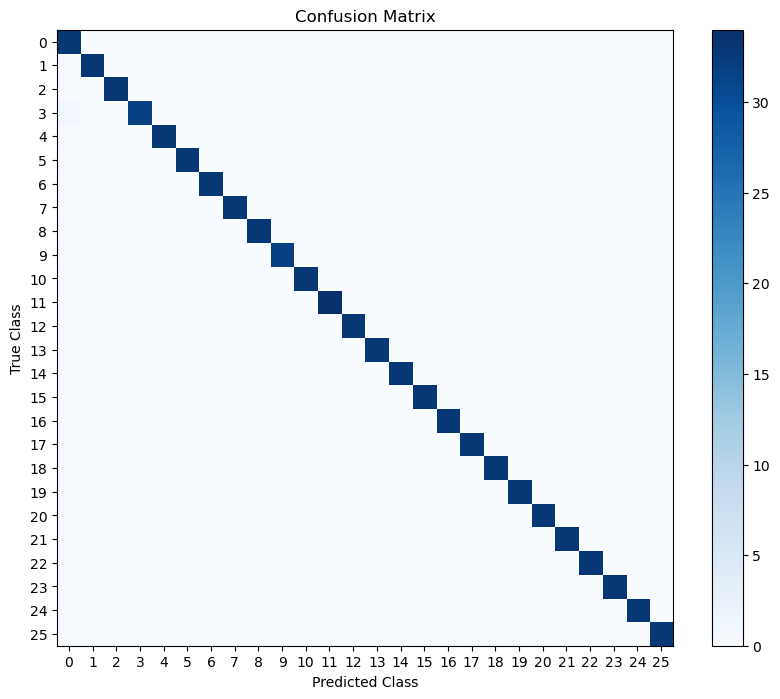

In [432]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(true_labels, max_indices)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(np.arange(26), range(26))  # Set the x-axis tick labels
plt.yticks(np.arange(26), range(26))  # Set the y-axis tick labels
plt.show()